In [1]:
import torch
import torch
import random
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
import numpy as np
import math
import h5py
import os
from math import log10

Commenting out the rotation augmentation which is mentioned in the paper. Predictions without rotation were found to be perceptually more pleasing. Note this might be the case for the epocs done here only.

Bicubic downsampling for training data is done here.

In [2]:
def load_img(filepath):
    img = Image.open(filepath).convert('YCbCr')
    y, _, _ = img.split()
    scale = random.uniform(0.9, 1)
    y = y.resize((int(y.size[0]*scale), int(y.size[1]*scale)), Image.BICUBIC)
    return y

In [3]:
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in ['.png', '.jpg', '.jpeg'])

In [4]:
torch.cuda.is_available()

True

This class will form our dataset

In [5]:
import torch.utils.data as data
import torchvision
from os import listdir
class DatasetFromFolder(data.Dataset):
    def __init__(self, image_dir, LR_transform=None, HR_2_transform=None, 
                                 HR_4_transform=None):
        super(DatasetFromFolder, self).__init__()
        self.image_filenames = [join(image_dir, x) for x in listdir(image_dir) if is_image_file(x)]

        self.LR_transform = LR_transform
        self.HR_2_transform = HR_2_transform
        self.HR_4_transform = HR_4_transform

    def __getitem__(self, index):
        input = load_img(self.image_filenames[index])
        HR_4 = self.HR_4_transform(input)
        HR_2 = self.HR_2_transform(HR_4)
        LR = self.LR_transform(HR_4)
        to_tensor = torchvision.transforms.ToTensor()
        HR_4 = to_tensor(HR_4)
        return LR, HR_2, HR_4

    def __len__(self):
        return len(self.image_filenames)

Functions to get the BSDS300 dataset

In [6]:
def get_training_set():
    root_dir = download_bsd300()
    train_dir = join(root_dir, "train")

    return DatasetFromFolder(train_dir,
                             LR_transform=LR_transform(crop_size),
                             HR_2_transform=HR_2_transform(crop_size),
                             HR_4_transform=HR_4_transform(crop_size))


def get_test_set():
    root_dir = download_bsd300()
    test_dir = join(root_dir, "test")

    return DatasetFromFolder(test_dir,
                             LR_transform=LR_transform(crop_size),
                             HR_2_transform=HR_2_transform(crop_size),
                             HR_4_transform=HR_4_transform(crop_size))

### Transformations done to create training dataset

Here only the training dataset for 4x resolution is done

In [7]:
def LR_transform(crop_size):
    return Compose([
        Scale(crop_size//4),
        ToTensor(),
    ])

def HR_2_transform(crop_size):
    return Compose([
        Scale(crop_size//2),
        ToTensor(),
    ])

def HR_4_transform(crop_size):
    return Compose([
        RandomCrop((crop_size, crop_size)),
        RandomHorizontalFlip(),
    ])

### Crop size chosen is 256 here

The paper was written using the crop size of 128.

In [8]:
from os.path import exists, join, basename
from os import makedirs, remove
from six.moves import urllib
import tarfile
from torchvision.transforms import Compose, CenterCrop, ToTensor, Scale, RandomCrop, RandomHorizontalFlip
crop_size =256
def download_bsd300(dest="dataset"):
    output_image_dir = join(dest, "BSDS300/images")

    if not exists(output_image_dir):
        makedirs(dest)
        url = "http://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz"
        print("downloading url ", url)

        data = urllib.request.urlopen(url)

        file_path = join(dest, basename(url))
        with open(file_path, 'wb') as f:
            f.write(data.read())

        print("Extracting data")
        with tarfile.open(file_path) as tar:
            for item in tar:
                tar.extract(item, dest)

        remove(file_path)

    return output_image_dir

In [9]:
train_set = get_training_set()
test_set = get_test_set()

downloading url  http://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz
Extracting data


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/transforms.py:210: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [10]:
from torch.utils.data import DataLoader
training_data_loader = DataLoader(dataset = train_set, num_workers = 1, batch_size = 64, shuffle = True)
testing_data_loader = DataLoader(dataset=test_set, num_workers=1, batch_size=64, shuffle=False)

In [11]:
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt
a = training_data_loader.dataset[0]
a[2].shape

torch.Size([1, 256, 256])

## Loss function

The charbonnier loss function is r(y, y_hat) = sqrt((y-y_hat)^2 + epsilon^2) which is found to be much more robust than the MSE.

The epsilon has been empirically chosen to be 1e-3 (as taken from the paper)

In [12]:
class L1_Charbonnier_loss(nn.Module):
    """L1 Charbonnierloss."""
    def __init__(self):
        super(L1_Charbonnier_loss, self).__init__()
        self.eps = 1e-3

    def forward(self, X, Y):
        diff = torch.add(X, -Y)
        error = torch.sqrt( diff * diff + self.eps * self.eps )
        loss = torch.sum(error) 
        return loss

## Architecture

![LapImage](https://imgur.com/a/ts6ZGcS)

The neural net directly interpolates and enlarges the image and to reconstruct it. We use a convolutional layer and an upsampling filter to enlarge layer by layer. This structure can perceive more information.

The network progressively reconstructs the sub-band residuals of high-resolution images at multiple pyramid levels, specifically at log2(S) levels where S is the scale factor (i.e., 2, 4, 8). This notebook is specifically for 4x resolution.

The model is based on the Laplacian pyramid structure, and the input is a low-resolution image, not an interpolated and filled image. The model consists of two parts, feature extraction and image reconstruction.

### Feature extraction - 

This establishes a nonlinear map through convolution and then upsample to obtain a graph. While during reconstruction, we first perform upsampling, and then directly add the feature extraction map to this map, which is equivalent to the fusion of the two maps.

Feature extraction involves 5 layers of convolutions with a leaky relu as non-linear function where the first layer has 1 as the in_channels (to account for the grayscale) and the further down convolutions have 64 filters. After the convolutions, we have a transposed convolution at the end.

### Image reconstruction - 

The images are upsampled from the lower resolution i.e. from the LR image to 2x or from 2x to 4x by the use of upsampling kernel kernel. The input image is upsampled by a scale of 2 with a transposed convolutional (upsampling) layer. As mentioned this layer is initialized with the bilinear kernel.

A transposed convolution on the features extracted from the previous resolution is then combined (using element-wise summation) with the predicted residual image from the feature extraction branch to produce a high-resolution output image.

### How does LapGAN differ from this one?

LAPGAN is upsampled and then passed down after convolution unlike the use of low-resolution images as inputs here. Also the use case of LapGANs are different.

In [13]:
def get_upsample_filter(size):
    """Make a 2D bilinear kernel suitable for upsampling"""
    factor = (size + 1) // 2
    if size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:size, :size]
    filter = (1 - abs(og[0] - center) / factor) * \
             (1 - abs(og[1] - center) / factor)
    return torch.from_numpy(filter).float()


64 filters in all convolutional layers except the first layer which applied on input image, the layers for predicting the residuals, and the image upsampling layer.

Filter size of the convolutional and transposed convolutional layers are 3×3 and 4×4 respectively.

Leaky ReLUs with slope of 0.2 is used.

Batch size of 64 and the size of HR patches is cropped as 128×128 for the paper however, I found better results for 256x256 images where the images being super resolved till 4x.

Data augmentation: (1) Scaling by randomly downscale images between [0.5, 1.0] in the paper, again better results found with scaling from [0.9, 1] perceptually (2) Random rotation of 90, 180 or 270 degrees in the paper. Found that perceptually much better results are achieved without the rotations although loss functions don't convey much details about that  (3) Random horizontally flipping with probability of 0.5.

In [14]:
class _Conv_Block(nn.Module):    
    def __init__(self):
        super(_Conv_Block, self).__init__()
        
        self.cov_block = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
    def forward(self, x):  
        output = self.cov_block(x)
        return output 


In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_input = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        
        self.convt_I1 = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=4, stride=2, padding=1, bias=False)
        self.convt_R1 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1, bias=False)
        self.convt_F1 = self.make_layer(_Conv_Block)
  
        self.convt_I2 = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=4, stride=2, padding=1, bias=False)
        self.convt_R2 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1, bias=False)
        self.convt_F2 = self.make_layer(_Conv_Block)        
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            if isinstance(m, nn.ConvTranspose2d):
                c1, c2, h, w = m.weight.data.size()
                weight = get_upsample_filter(h)
                m.weight.data = weight.view(1, 1, h, w).repeat(c1, c2, 1, 1)
                if m.bias is not None:
                    m.bias.data.zero_()
                    
    def make_layer(self, block):
        layers = []
        layers.append(block())
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.conv_input(x))
        
        convt_F1 = self.convt_F1(out)
        convt_I1 = self.convt_I1(x)
        convt_R1 = self.convt_R1(convt_F1)
        HR_2x = convt_I1 + convt_R1
        HR_2x = HR_2x.cuda()
        
        convt_F2 = self.convt_F2(convt_F1)
        convt_I2 = self.convt_I2(HR_2x)
        convt_R2 = self.convt_R2(convt_F2)
        HR_4x = convt_I2 + convt_R2
        HR_4x = HR_4x.cuda()
        return HR_2x, HR_4x

Since the GPU is being used right now, all the data is being directly put into cuda

In [16]:
okay = iter(training_data_loader)
first = next(okay)
first[0].shape

torch.Size([64, 1, 64, 64])

This is the image of our label for the first image in our training dataloader 

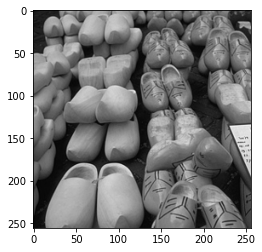

In [17]:
plt.imshow(first[2][0][0].cpu(), cmap = 'gray')

### Object for hyperparameters

In [18]:
class lapinit():
    def __init__(self, batchSize = 64, nEpochs = 100, lr = 1e-4, step = 100,
            cuda = {'action' : True}, resume = '', start_epoch = 1, threads = 1,
            momentum = 0.9, weight_decay = 1e-4, pretrained = ''):
        self.batchSize = batchSize
        self.nEpochs = nEpochs
        self.lr = lr
        self.step = step
        self.cuda = cuda
        self.resume = resume
        self.start_epoch = start_epoch
        self.threads = threads
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.pretrained = pretrained

opt = lapinit()

Shifting all the data of the model to cuda so that GPU can be used

In [19]:
model = Net()
model = model.cuda()
criterion = L1_Charbonnier_loss()

In [20]:
first[0] = first[0].cuda()
tmp1, tmp2 = model(first[0])
tmp1.shape, tmp2.shape

(torch.Size([64, 1, 128, 128]), torch.Size([64, 1, 256, 256]))

### Optimizer

In [21]:
optimizer = optim.Adam(model.parameters(), lr=opt.lr)

In [22]:
def train(training_data_loader, optimizer, model, criterion, epoch):

    lr = adjust_learning_rate(optimizer, epoch-1)

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

    print("Epoch={}, lr={}".format(epoch, optimizer.param_groups[0]["lr"]))

    model.train()

    for iteration, batch in enumerate(training_data_loader, 1):

        input, label_x2, label_x4 = Variable(batch[0]), Variable(batch[1], requires_grad=False), Variable(batch[2], requires_grad=False)
            
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            input, label_x2, label_x4 = input.to(device), label_x2.to(device), label_x4.to(device)

        HR_2x, HR_4x = model(input)
        loss_x2 = criterion(HR_2x, label_x2)
        loss_x4 = criterion(HR_4x, label_x4)
        loss = loss_x2 + loss_x4

        optimizer.zero_grad()

        loss_x2.backward(retain_graph=True)

        loss_x4.backward(retain_graph=True)

        optimizer.step()

        if iteration%100 == 0:
            print("===> Epoch[{}]({}/{}): Loss: {:.10f}".format(epoch, iteration, len(training_data_loader), loss.data[0]))


In [23]:
def save_checkpoint(model, epoch):
    model_folder = "checkpoint/"
    model_out_path = model_folder + "lapsrn_model_epoch_{}.pth".format(epoch)
    state = {"epoch": epoch ,"model": model, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
    if not os.path.exists(model_folder):
        os.makedirs(model_folder)

    torch.save(state, model_out_path)

    print("Checkpoint saved to {}".format(model_out_path))


In [24]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 10 epochs"""
    lr = opt.lr * (0.1 ** (epoch // opt.step))
    return lr

In [25]:

def test():
    avg_psnr1 = 0
    avg_psnr2 = 0
    for batch in testing_data_loader:
        LR, HR_2_target, HR_4_target = Variable(batch[0]), Variable(batch[1]), Variable(batch[2])
        
        if torch.cuda.is_available():
            LR = LR.cuda()
            HR_2_target = HR_2_target.cuda()
            HR_4_target = HR_4_target.cuda()

        HR_2, HR_4 = model(LR)
        mseloss = nn.MSELoss()
        mse1 = mseloss(HR_2, HR_2_target)
        mse2 = mseloss(HR_4, HR_4_target)
        psnr1 = 10 * log10(1 / torch.Tensor.tolist(mse1))
        psnr2 = 10 * log10(1 / torch.Tensor.tolist(mse2))
        avg_psnr1 += psnr1
        avg_psnr2 += psnr2
    print("Avg. PSNR for 2x: {:.4f} dB".format(avg_psnr1 / len(testing_data_loader)))
    print("Avg. PSNR for 4x: {:.4f} dB".format(avg_psnr2 / len(testing_data_loader)))
    return avg_psnr1/len(testing_data_loader), avg_psnr2/len(testing_data_loader)

In [26]:
y = []
x = [i for i in range(opt.nEpochs)]
for epoch in range(opt.start_epoch, opt.nEpochs + 1):
    train(training_data_loader, optimizer, model, criterion, epoch)
    # save_checkpoint(model, epoch)
    if epoch%100==0:
        save_checkpoint(model, epoch)
    y.append(test())

Epoch=1, lr=0.0001
Avg. PSNR for 2x: -12.1728 dB
Avg. PSNR for 4x: -12.1422 dB
Epoch=2, lr=0.0001
Avg. PSNR for 2x: 1.4253 dB
Avg. PSNR for 4x: 1.8743 dB
Epoch=3, lr=0.0001
Avg. PSNR for 2x: 3.7364 dB
Avg. PSNR for 4x: 3.5552 dB
Epoch=4, lr=0.0001
Avg. PSNR for 2x: 6.3602 dB
Avg. PSNR for 4x: 6.7488 dB
Epoch=5, lr=0.0001
Avg. PSNR for 2x: 3.4942 dB
Avg. PSNR for 4x: 4.1135 dB
Epoch=6, lr=0.0001
Avg. PSNR for 2x: 9.0982 dB
Avg. PSNR for 4x: 10.7434 dB
Epoch=7, lr=0.0001
Avg. PSNR for 2x: 7.6791 dB
Avg. PSNR for 4x: 11.8788 dB
Epoch=8, lr=0.0001
Avg. PSNR for 2x: 8.5148 dB
Avg. PSNR for 4x: 11.7343 dB
Epoch=9, lr=0.0001
Avg. PSNR for 2x: 10.8724 dB
Avg. PSNR for 4x: 15.0794 dB
Epoch=10, lr=0.0001
Avg. PSNR for 2x: 13.4172 dB
Avg. PSNR for 4x: 15.4359 dB
Epoch=11, lr=0.0001
Avg. PSNR for 2x: 13.1042 dB
Avg. PSNR for 4x: 14.1511 dB
Epoch=12, lr=0.0001
Avg. PSNR for 2x: 14.6769 dB
Avg. PSNR for 4x: 16.0557 dB
Epoch=13, lr=0.0001
Avg. PSNR for 2x: 14.7881 dB
Avg. PSNR for 4x: 17.1857 dB
Epoc

/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type _Conv_Block. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Avg. PSNR for 2x: 23.2947 dB
Avg. PSNR for 4x: 21.9591 dB


### Graph for PSNR of 4x(orange) and 2x(blue) vs epochs

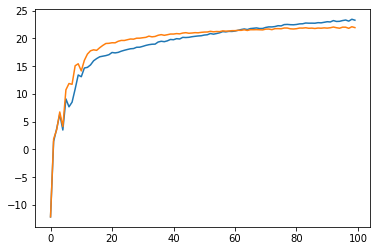

In [28]:
plt.plot(x, y)

In [29]:
okay = iter(testing_data_loader)
test1 = next(okay)
test1[0].shape

torch.Size([64, 1, 64, 64])

In [30]:
test1[0] = test1[0].cuda()
tmp1, tmp2 = model(test1[0])

In [31]:
test1[0][0].shape

torch.Size([1, 64, 64])

### Testing model on a test dataset

We are going to test our model on this image

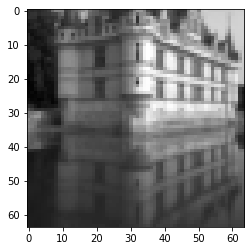

In [32]:
plt.imshow(test1[0][0][0].cpu(), cmap = 'gray')

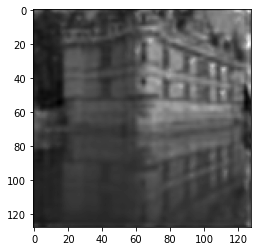

In [33]:
plt.imshow(tmp1[0][0].detach().cpu(), cmap = 'gray')

The 4x resolution prediction by our model is - 

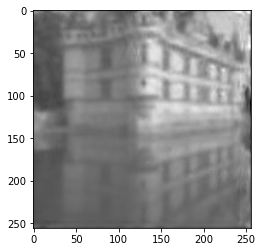

In [34]:
plt.imshow(tmp2[0][0].detach().cpu(), cmap = 'gray')

Actual image is

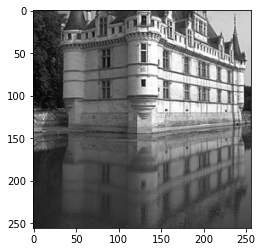

In [35]:
plt.imshow(test1[2][0][0].cpu(), cmap = 'gray')